In [331]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns

# training and testing dataset split
from sklearn.model_selection import train_test_split

# logistic regression and feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV


# Load Data

In [78]:
df_train = pd.read_csv('train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# check data type and missing data

In [79]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [80]:
df_train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

# Note: 
- missing data in Sex, Cabin, Embarked:

|Age|Cabin|Embarked|
|---|---|---|
|filled in 199|filled in "Missing"|Imputed Passengerid 62 and 830 to "U"|

- survival by class, by sex: 
    - 3 female in first class died
    - 2 are mother and daughter
    - The mother had two kids (one daughter died, one son survived)
    - The mother had a single female sibling survived

- survival by family size(number of tickets bought/counts by ticket number)
    - by family size, by class, by sex:
    - 1st class female close to 100%
    - 1st class female with family size 2: 100%
    - 1st class male with family size 2: higher survival than single
    - 2nd class similar to 1st
    - 3rd class size 1-2: female 50%
    - 3rd class anomalies: 
        - size 4 female: 4 survived, mother with 3 kids (ticket 2666)
        - size 7 male: 5 survived, anomaly. A group of Asian males. Managed to rescue themselves. check on news. (ticket 1601) *These data will be removed as anomaly. A recent documentary movie "The Six" talked about these survivors. https://www.imdb.com/title/tt8517640/

- survival by Age
    - missing age: 1st and 2nd class female all survived
    

In [81]:
df_train[df_train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [82]:
# look for the same ticket number or Cabin
#df_train[df_train.Ticket == '113572']
#df_train[df_train.Cabin == 'B28']
# impute Embarked as "U"
df_train.Embarked = df_train.Embarked.fillna('U')
df_train[df_train.Ticket == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,U
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,U


In [83]:
df_train[df_train.Name.str.contains('Icard')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,U


In [85]:
#age missing impute 199
df_train.Age = df_train.Age.fillna(199)
df_train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
dtype: bool

In [115]:
#cabin missing, fill in "Missing"
df_train.Cabin = df_train.Cabin.fillna('Missing')
df_train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

# Change Data Type

In [118]:
df_train.Pclass = df_train.Pclass.astype('str')
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass          object
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Data Exploration

##### Survival rate by Pclass

In [119]:
df_t_class = df_train.groupby(['Pclass']).mean().reset_index()
df_t_class

,Pclass,PassengerId,Survived,Age,SibSp,Parch,Fare
0,1,461.597222,0.629630,60.562130,0.416667,0.356481,84.154687
1,2,445.956522,0.472826,39.988207,0.402174,0.380435,20.662183
2,3,439.154786,0.242363,73.297189,0.615071,0.393075,13.675550


In [122]:
p1 = px.bar(df_t_class, x = 'Pclass', y = 'Survived')
p1.show()

##### Survival rate by Gender

In [124]:
df_t_gender = df_train.groupby('Sex').mean().reset_index()
df_t_gender

,Sex,PassengerId,Survived,Age,SibSp,Parch,Fare
0,female,431.028662,0.742038,56.792994,0.694268,0.649682,44.479818
1,male,454.147314,0.188908,66.889376,0.429809,0.235702,25.523893


In [125]:
p2 = px.bar(df_t_gender, x = 'Sex', y = 'Survived')
p2.show()

##### survival rate by class by gender

In [126]:
summary = df_train.groupby(['Sex', 'Pclass']).mean().Survived.reset_index()
summary

,Sex,Pclass,Survived
0,female,1,0.968085
1,female,2,0.921053
2,female,3,0.500000
3,male,1,0.368852
4,male,2,0.157407
5,male,3,0.135447


In [128]:
p3 = px.bar(summary, color = 'Pclass', y = 'Survived', x = 'Sex')
p3.show()

##### counts by Survive, by Pclass, by Sex

In [136]:
ct = df_train.groupby(['Sex', 'Pclass', 'Survived']).count().PassengerId.reset_index()
ct

,Sex,Pclass,Survived,PassengerId
0,female,1,0,3
1,female,1,1,91
2,female,2,0,6
3,female,2,1,70
4,female,3,0,72
5,female,3,1,72
6,male,1,0,77
7,male,1,1,45
8,male,2,0,91
9,male,2,1,17


In [138]:
p4 = px.bar(ct[ct.Survived == 1], x = 'Pclass', y = 'PassengerId', color = 'Sex')
p4.show()

In [146]:
# 3 female from 1st class died
df_train[(df_train.Sex == 'female')&(df_train.Pclass == '1')&(df_train.Survived == 0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
177,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,C22 C26,S


In [148]:
df_train[df_train.Cabin.str.contains('C26')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S


In [149]:
df_train[df_train.Ticket == '113781']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S
708,709,1,1,"Cleaver, Miss. Alice",female,22.00,0,0,113781,151.55,Missing,S


In [155]:
#df_train[df_train.Ticket.str.contains('17595')]
#df_train[df_train.Cabin == 'C49']
df_train[df_train.Name.str.contains('Isham')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
177,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C


In [184]:
# count by Ticket number and survived by Ticket number
# create a dummy column 1
df_train['Ct'] = 1
ctTicket = df_train.groupby(['Ticket', 'Pclass', 'Sex']).sum().reset_index()
ctTicket1 = ctTicket[['Ticket','Pclass', 'Sex','Survived','Ct']]

In [185]:
ctTicket1.groupby(['Pclass', 'Sex', 'Ct']).mean().Survived.reset_index()

,Pclass,Sex,Ct,Survived
0,1,female,1,0.976744
1,1,female,2,2.000000
2,1,female,3,2.600000
3,1,male,1,0.358491
4,1,male,2,0.875000
5,2,female,1,0.892857
6,2,female,2,2.000000
7,2,male,1,0.129412
8,2,male,2,0.666667
9,2,male,3,1.000000


In [189]:
ctTicket1[((ctTicket1.Ct == 7) & (ctTicket1.Sex == 'male')) | ((ctTicket1.Ct == 4) & (ctTicket1.Sex == 'female'))]

,Ticket,Pclass,Sex,Survived,Ct
92,1601,3,male,5,7
227,2666,3,female,4,4


In [191]:
df_train[(df_train.Ticket == '1601') | (df_train.Ticket=='2666')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ct
74,75,1,3,"Bing, Mr. Lee",male,32.00,0,0,1601,56.4958,Missing,S,1
169,170,0,3,"Ling, Mr. Lee",male,28.00,0,0,1601,56.4958,Missing,S,1
448,449,1,3,"Baclini, Miss. Marie Catherine",female,5.00,2,1,2666,19.2583,Missing,C,1
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,Missing,C,1
509,510,1,3,"Lang, Mr. Fang",male,26.00,0,0,1601,56.4958,Missing,S,1
643,644,1,3,"Foo, Mr. Choong",male,199.00,0,0,1601,56.4958,Missing,S,1
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,Missing,C,1
692,693,1,3,"Lam, Mr. Ali",male,199.00,0,0,1601,56.4958,Missing,S,1
826,827,0,3,"Lam, Mr. Len",male,199.00,0,0,1601,56.4958,Missing,S,1
838,839,1,3,"Chip, Mr. Chang",male,32.00,0,0,1601,56.4958,Missing,S,1


##### survival by age

In [229]:
summary = df_train[df_train.Age != 199].groupby(['Survived', 'Pclass', 'Sex']).mean().Age.reset_index()
#summary
p5 = px.bar(summary[summary.Pclass == '1'], y = 'Age', x = 'Survived', color = 'Sex', barmode = 'group', title = 'First Class')
p6 = px.bar(summary[summary.Pclass == '2'], y = 'Age', x = 'Survived', color = 'Sex', barmode = 'group', title = 'Second Class')
p7 = px.bar(summary[summary.Pclass == '3'], y = 'Age', x = 'Survived', color = 'Sex', barmode = 'group', title = 'Third Class')
p5.show()
p6.show()
p7.show()

# remove anomalies and create features

In [193]:
# remove ticket 1601
df = df_train[df_train.Ticket != '1601']

In [291]:
# may not use columns "PassengerId", "Name"
# feature engineering: 
# 1) Number of tickets bought
# 2) Single: Travel without Siblings or Parent or Child
# 3) Age Group (<1, 1-3, 3-10, 11-20, 21- 30, 31-40, 41-50, 51-60, 61 - 120, 121+)
# 4) Sex F vs M
# 5) Pclass 1st, 2nd, vs 3rd

# calculate number of tickets
ntkt = df.groupby('Ticket').count().Name.reset_index()
# rename number of tickets to Pcount
ntkt['Pcount'] = ntkt.Name
ntkt = ntkt[['Ticket', 'Pcount']]
# join ntkt to get Pcount - Passenger counts per ticket
df1 = df.merge(ntkt, left_on = 'Ticket', right_on = 'Ticket', how = 'left')
# create single traveler
df1['Single'] = np.where(df1.SibSp + df1.Parch > 0, 0, 1)
#df1[(df1.Pcount != 1) & (df1.Single == 1)]
df1['SingleOnTicket'] = np.where(df1.Pcount == 1, 1, 0)
df1['SexF'] = np.where(df1.Sex == 'female', 1, 0)
df1['FirstClass'] = np.where(df1.Pclass == '1', 1, 0)
df1['SecondClass'] = np.where(df1.Pclass == '2', 1, 0)

In [272]:
# survival rate by Single on Ticket
summary = df1.groupby('SingleOnTicket').mean().Survived.reset_index()
summary.head()

,SingleOnTicket,Survived
0,0,0.516320
1,1,0.297989


In [274]:
# survival rate by Single
summary = df1.groupby(['Single','SingleOnTicket']).mean().Survived.reset_index()
summary.head()

,Single,SingleOnTicket,Survived
0,0,0,0.524164
1,0,1,0.447059
2,1,0,0.485294
3,1,1,0.270563


# Training Model
## set up train and test set

In [294]:
dfX = df1.drop('Survived', axis = 1)

In [295]:
X_train, X_test, y_train, y_test = train_test_split(
    dfX, 
    df1.Survived, 
    test_size = 0.33, 
    random_state = 0)


## variable selection

In [305]:
col = ['Pcount', 'FirstClass', 'SecondClass', 'SexF', 'Age', 'SibSp', 'Parch', 'Fare', 'Single', 'SingleOnTicket']

In [308]:
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 5)
rfe = rfe.fit(X_train[col], y_train)
# summarize the selection of the attributes
print('Selected features: %s' % list(X_train[col].columns[rfe.support_]))

Selected features: ['Pcount', 'FirstClass', 'SecondClass', 'SexF', 'SingleOnTicket']


In [312]:

sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)


Optimal number of features: 8
Selected features: ['Pcount', 'FirstClass', 'SecondClass', 'SexF', 'SibSp', 'Parch', 'Single', 'SingleOnTicket']


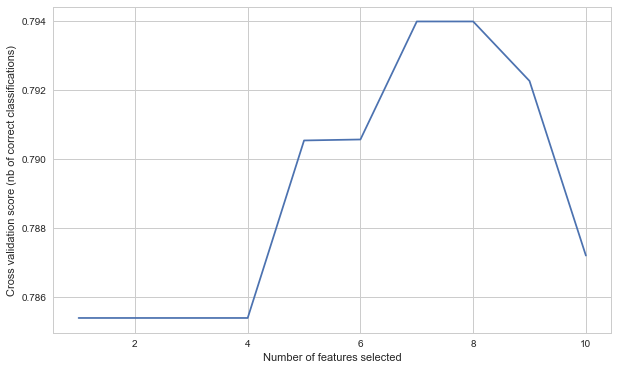

In [313]:
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X_train[col], y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X_train[col].columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

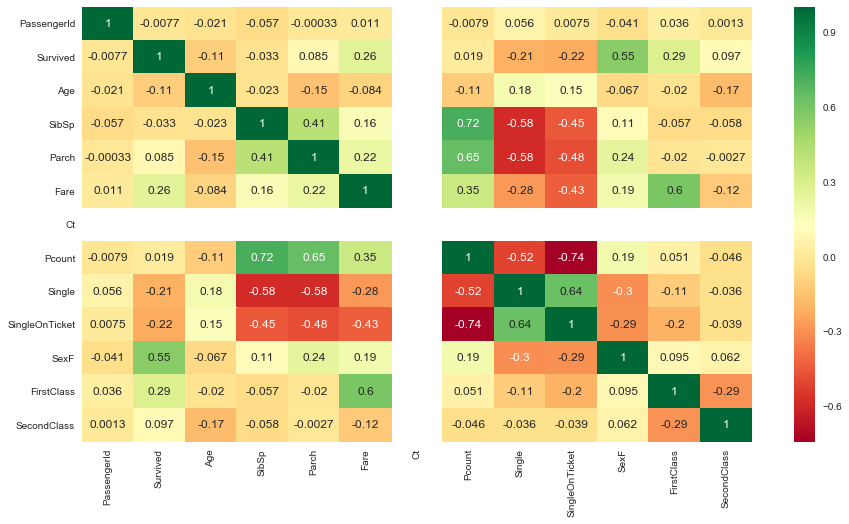

In [341]:
X = df1

plt.subplots(figsize=(15, 8))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

# logistic regression

In [323]:
mdcol = ['Pcount', 'FirstClass', 'SecondClass', 'SexF']
md = LogisticRegression(random_state=0).fit(X_train[mdcol], y_train)


In [324]:
md.predict(X_test[mdcol])


array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0])

In [327]:
md.predict_proba(X_test[mdcol])

array([[0.34239227, 0.65760773],
       [0.39527005, 0.60472995],
       [0.87912068, 0.12087932],
       [0.09359464, 0.90640536],
       [0.13995834, 0.86004166],
       [0.53465155, 0.46534845],
       [0.90128354, 0.09871646],
       [0.13995834, 0.86004166],
       [0.18848416, 0.81151584],
       [0.87912068, 0.12087932],
       [0.34239227, 0.65760773],
       [0.22575269, 0.77424731],
       [0.34239227, 0.65760773],
       [0.76438835, 0.23561165],
       [0.53465155, 0.46534845],
       [0.76438835, 0.23561165],
       [0.09359464, 0.90640536],
       [0.18848416, 0.81151584],
       [0.07600186, 0.92399814],
       [0.80287006, 0.19712994],
       [0.64421508, 0.35578492],
       [0.07600186, 0.92399814],
       [0.53465155, 0.46534845],
       [0.95776379, 0.04223621],
       [0.34239227, 0.65760773],
       [0.67083873, 0.32916127],
       [0.80287006, 0.19712994],
       [0.87912068, 0.12087932],
       [0.87912068, 0.12087932],
       [0.87912068, 0.12087932],
       [0.

In [325]:
md.score(X_test[mdcol], y_test)

0.8184931506849316

In [329]:
# change the decision threshold
preds = np.where(md.predict_proba(X_test[mdcol])[:,1] > 0.8, 1, 0)

In [330]:
preds

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])